In [224]:
import scanpy as sc
import anndata as ad
import pandas as pd

In [225]:
count_df=pd.read_csv('data/8_antenna.tsv.gz', compression='gzip', sep='\t',header=None, index_col=0)
count_df.index.name=''
count_df=count_df.T

In [226]:
count_df

,128up,14-3-3epsilon,14-3-3zeta,140up,18SrRNA-Psi:CR41602,18w,26-29-p,28SrRNA-Psi:CR40596,28SrRNA-Psi:CR40741,28SrRNA-Psi:CR41609,...,zetaCOP,zf30C,zfh1,zfh2,zip,zld,zormin,zpg,zuc,zyd
1,0,2,3,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,1,3,0,0,3,0,0,0
3,0,2,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,0,0,0
5,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
5591,0,1,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
5592,0,4,7,0,0,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,0


In [227]:
adata = sc.AnnData(count_df)
adata

/Users/guillaumebelissent/opt/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/guillaumebelissent/opt/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 5593 × 11881

# Removing Zeros

In [228]:
pd.Series(count_df.columns.str.startswith('mt')).sum()

40

# Quality Control

None


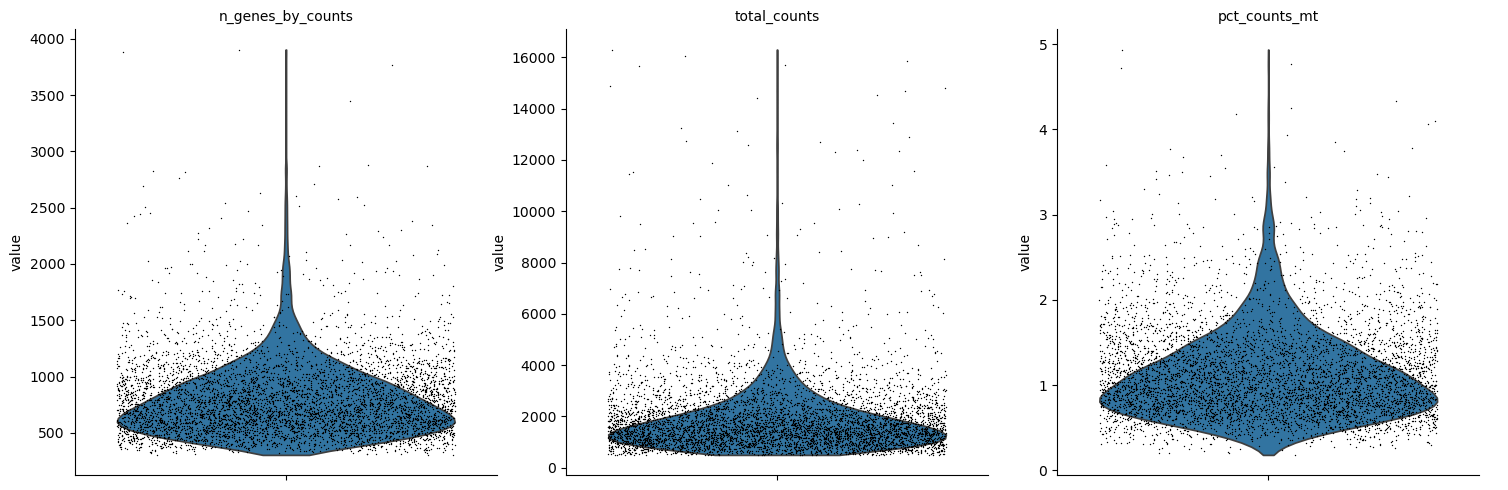

In [229]:
sc.pp.filter_cells(adata, min_genes=1)  # Adjust the threshold as needed
sc.pp.filter_cells(adata, min_counts=1)  # Adjust the threshold as needed

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
print(sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
))
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

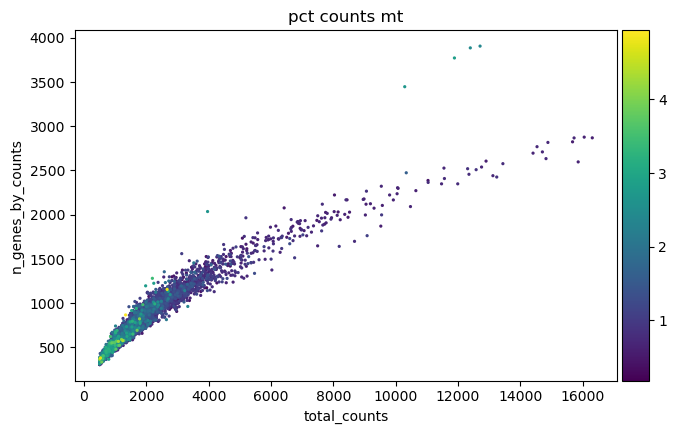

In [230]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Doublet Detection

In [231]:
#sc.pp.scrublet(adata)
sc.pp.filter_cells(adata, max_counts=10000)  # Adjust the threshold as needed
sc.pp.filter_cells(adata, max_genes=3000)  # Adjust the threshold as needed

In [232]:
import numpy as np
print("Min counts:", np.min(adata.X))
print("Max counts:", np.max(adata.X))
print("Mean counts:", np.mean(adata.X))

Min counts: 0
Max counts: 494
Mean counts: 0.1534978117455739


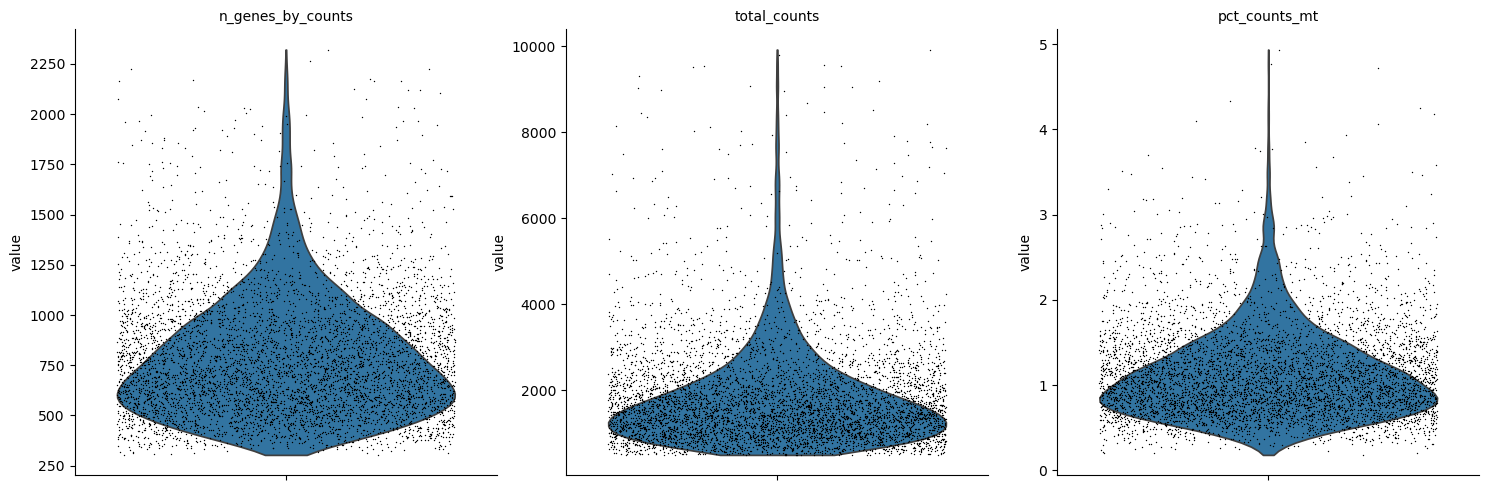

In [233]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# Normalisation

In [234]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# Feature Selection

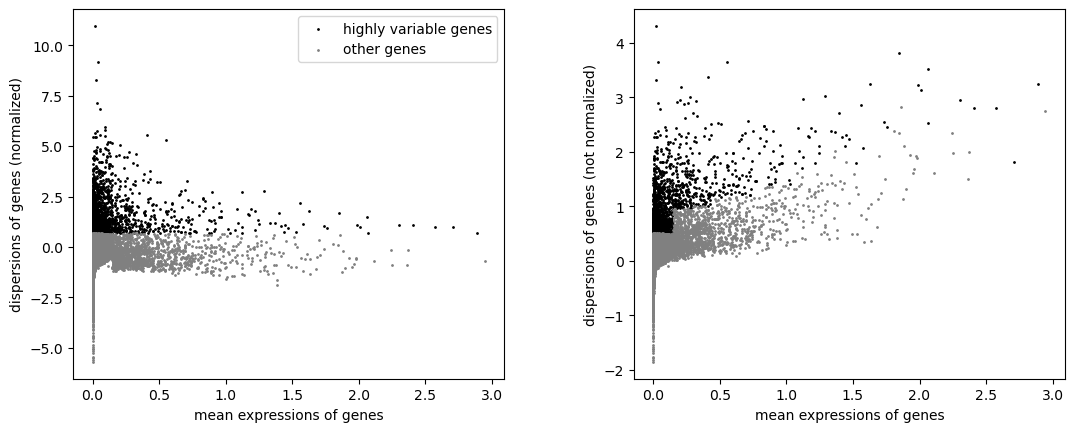

In [235]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

# Dimensionality reduction

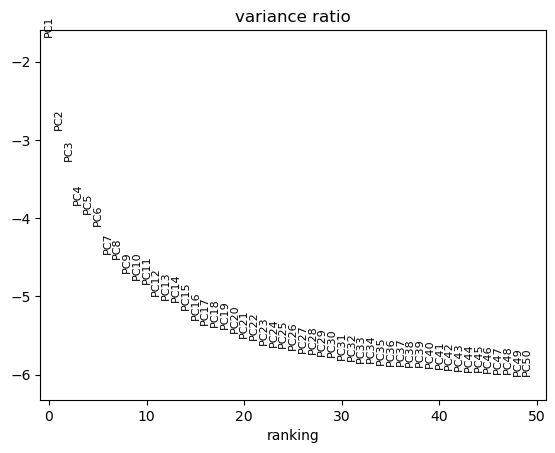

In [236]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

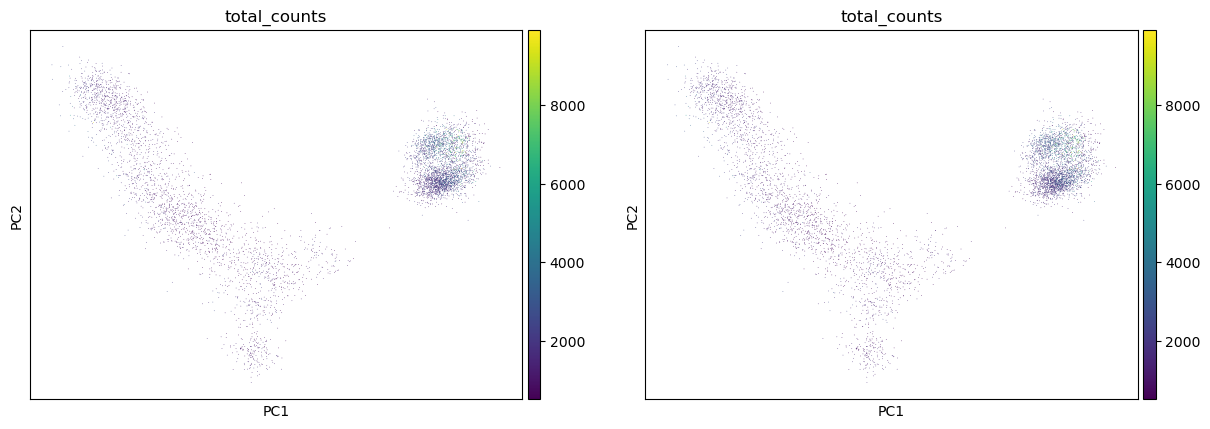

In [237]:
sc.pl.pca(
    adata,
    color=["total_counts", "total_counts"],
    dimensions=[(0, 1), (0, 1)],
    ncols=2,
    size=1,
)

# Nearest Neighbors

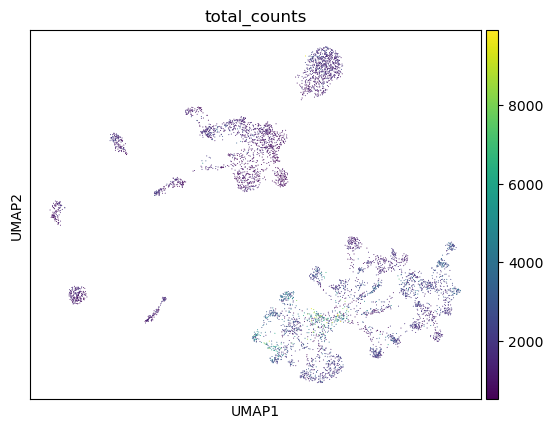

In [238]:
sc.pp.neighbors(adata)

sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="total_counts",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

# Clustering

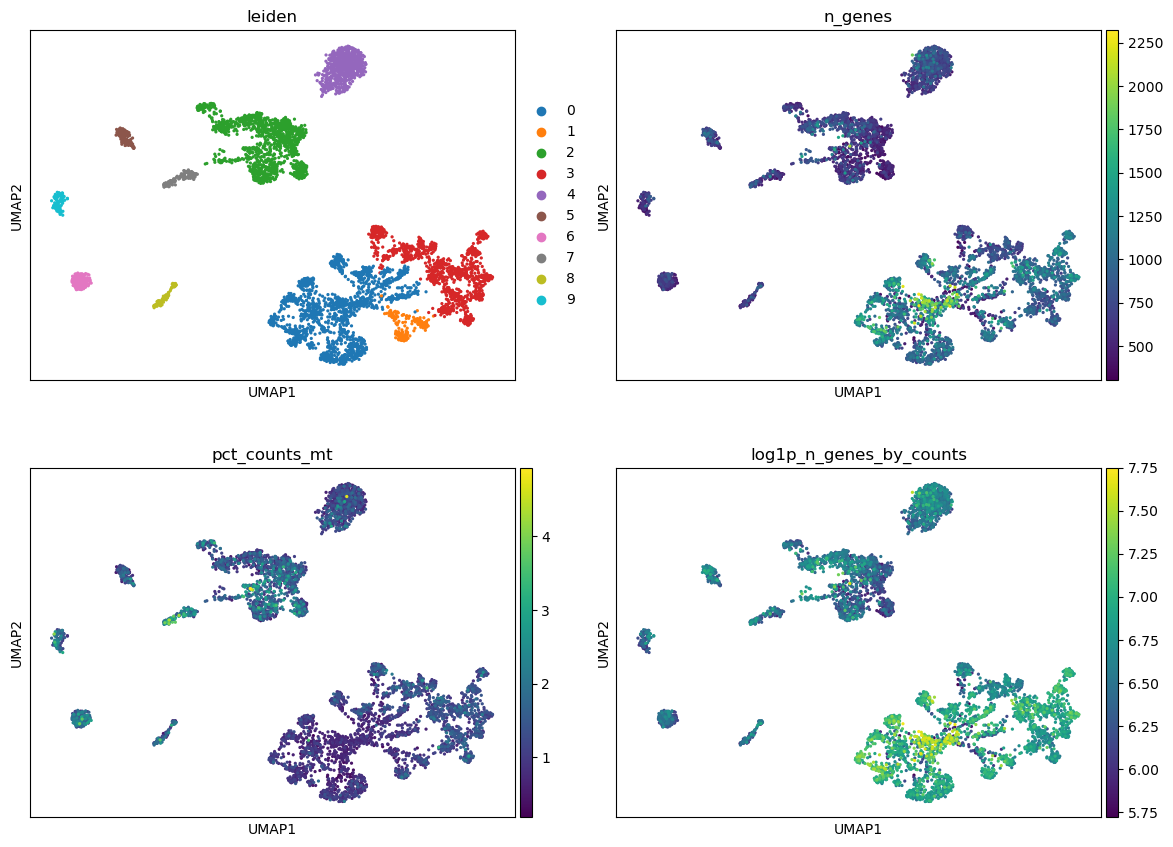

In [239]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2,resolution=0.1)
sc.pl.umap(
    adata,
    color=["leiden", "n_genes", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.1,
    ncols=2,
)

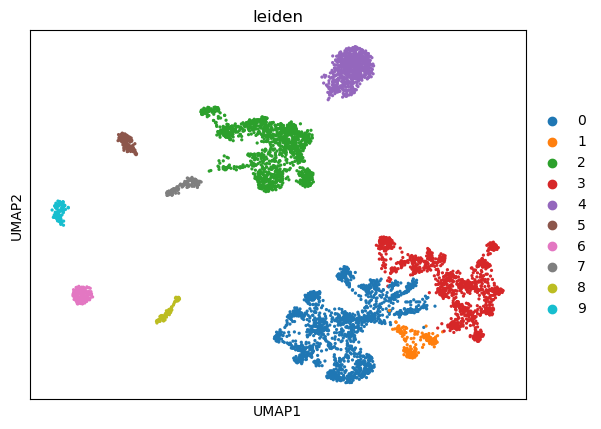

In [245]:
sc.pl.umap(adata, color='leiden')

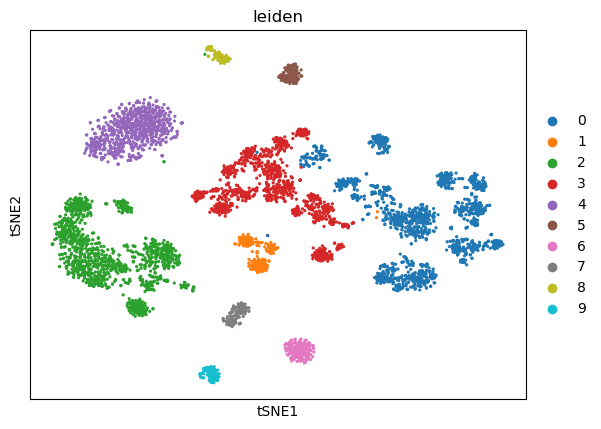

In [244]:
sc.pl.tsne(adata, color='leiden')

# Marker Genes

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_7149/1122589896.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_markers = markers[markers.pvals_adj < 0.05].groupby('group').head(5)


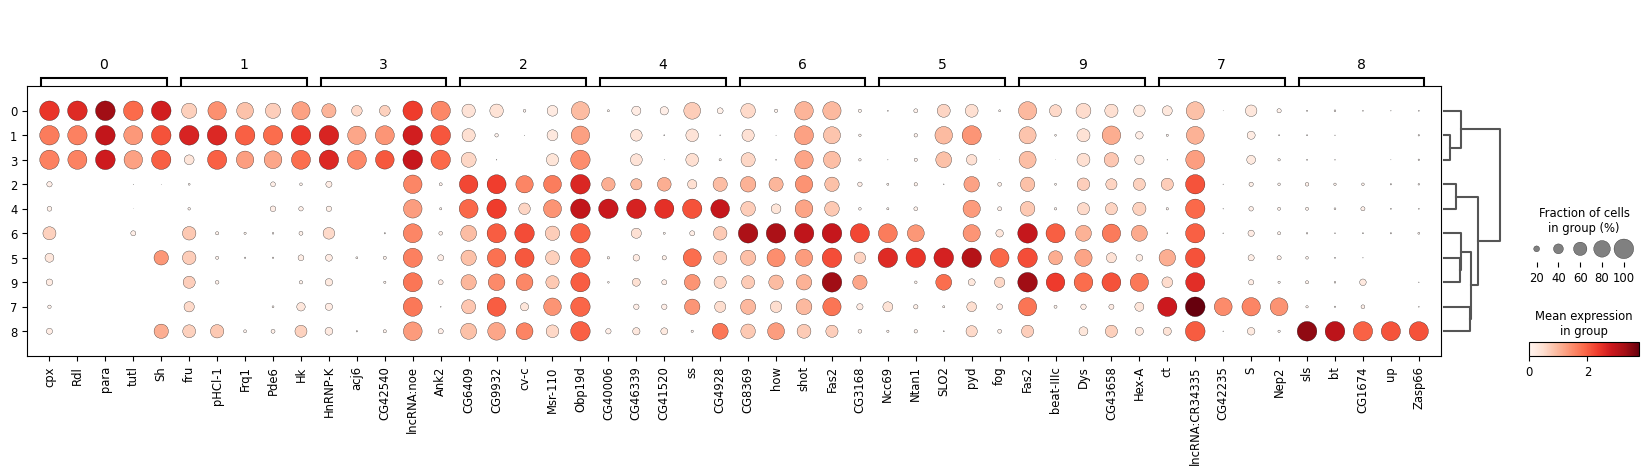

In [248]:
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',          # Cluster labels (e.g., 'leiden' or 'louvain')
    method='wilcoxon',         # Default: Wilcoxon rank-sum test
    key_added='rank_genes_groups'     # Key to store results in adata.uns
)
# Get top 5 markers per cluster
markers = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_groups')
top_markers = markers[markers.pvals_adj < 0.05].groupby('group').head(5)

sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden', n_genes=5)
#sc.pl.rank_genes_groups_heatmap(adata, groupby='leiden', n_genes=5)

para (0,1,3): neuron 
bt, sls (8): muscle 
CG42235 (7): adult glial cells
CG46339, ... (4): epithelial cells
Ncc69 (5): adult glial cell


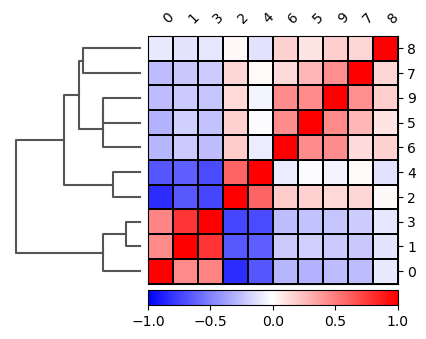

In [247]:
sc.pl.correlation_matrix(adata, "leiden", figsize=(5, 3.5))

#### Observed super-groups:
Using the dendrogram we can determine larger groups of cells that we can gather GO annotations for to perhaps determine their function.

Group 1: 15, 8, 6, 9

Group 2: 20, 0, 4, 12, 17, 10, 16, 5, 11 

Group 3: 3, 7, 19, 2, 13

Group 4: 21, 1, 22

Group 5: 14, 18

# Functional Enrichement

In [211]:
enriched_dfs = []
for group, names in top_markers.groupby('group')['names'].apply(lambda x: x.tolist()).to_dict().items():
    enriched_df = sc.queries.enrich(names, org='dmelanogaster')
    enriched_df['group'] = group  # Add the group as a column
    enriched_dfs.append(enriched_df)

# Step 2: Concatenate all the DataFrames
enriched_df = pd.concat(enriched_dfs, ignore_index=True)

# final_df now contains the concatenated DataFrame with the 'group' column

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_7149/575271069.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, names in top_markers.groupby('group')['names'].apply(lambda x: x.tolist()).to_dict().items():
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_7149/575271069.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  enriched_df = pd.concat(enriched_dfs, ignore_index=True)


In [214]:
group_1  = [15, 8, 6, 9]
group_2= [20, 0, 4, 12, 17, 10, 16, 5, 11]
group_3= [3, 7, 19, 2, 13]
group_4= [21, 1, 22]
group_5=[14, 18]
print('group 1 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_1)]['name'].unique():
    print(name)
print('\n\ngroup 2 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_2)]['name'].unique():
    print(name)
print('\n\ngroup 3 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_3)]['name'].unique():
    print(name)
print('\n\ngroup 4 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_4)]['name'].unique():
    print(name)
print('\n\ngroup 5 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_5)]['name'].unique():
    print(name)

group 1 GO annotations:
negative regulation of secretion by cell
negative regulation of secretion
dme-let-7-5p
response to mechanical stimulus
membrane protein complex
transmembrane transporter complex
transporter complex
transmembrane transporter activity
transporter activity
inorganic molecular entity transmembrane transporter activity
monoatomic ion channel complex
monoatomic ion transmembrane transporter activity
chemical synaptic transmission
anterograde trans-synaptic signaling
trans-synaptic signaling
synaptic signaling
inorganic ion transmembrane transport
regulation of membrane potential
cell-cell signaling
plasma membrane protein complex
action potential
response to abiotic stimulus
monoatomic ion transmembrane transport
metal ion transmembrane transporter activity
gated channel activity
modulation of chemical synaptic transmission
regulation of trans-synaptic signaling
monoatomic ion transport
behavior
monoatomic ion channel activity
nervous system process
inorganic cation t

### **Group 1**  
**Key Terms and Definitions:**  
- **Ion transport/channel activity** (e.g., *voltage-gated ion channels*, *transmembrane transporter activity*): Proteins regulating ion flow across membranes, critical for electrical signaling.  
- **Synaptic signaling** (e.g., *chemical synaptic transmission*, *synaptic signaling*): Processes involved in neurotransmitter release and neuronal communication.  
- **Membrane protein complexes** (e.g., *plasma membrane protein complex*): Structures mediating cell signaling or transport.  
- **Regulation of membrane potential** and **action potential**: Electrical properties of excitable cells.  
- **Response to mechanical/abiotic stimuli**: Sensitivity to physical changes in the environment.  

**Hypothesis:**  
- These cells may be **neurons or electrically excitable cells** (e.g., neurons, neuroendocrine cells). They are likely involved in **synaptic transmission, ion homeostasis, and sensory processing**. There are terms that mention 'response to stimulus suggesting that this group may contain **sensory neurons**.
---

### **Group 2**  
**Key Terms and Definitions:**  
- **Neuronal compartments** (e.g., *neuronal cell body*, *axon*, *postsynaptic membrane*): Structural components of neurons.  
- **Trascription regulation** (e.g., *mRNA binding* and *calmodulin binding*, *Factor: Aef1*) Regulation of gene expression and calcium signaling.  
- **G protein-coupled receptor (GPCR) signaling**: Cell communication via receptors linked to intracellular pathways.  
- **Small conductance calcium-activated potassium channels**: Modulate neuronal excitability.  

**Hypothesized Function/Cell Type:**  
- **Neuronal subtypes with regulatory roles** (e.g., **motor neurons**, **interneurons**, or **secretory neurons**).  
- Functions may include **maintaining cell size**, **calcium-dependent signaling**, and **axonal transport**.  
- The presence of **apolipoprotein binding** hints at lipid metabolism involvement, possibly **glia-neuron interactions** (e.g., astrocytes supporting neurons).  

---

### **Group 3**  
**Key Terms and Definitions:**  
- **Cytoskeletal organization** (e.g., *actin binding*, *microtubule plus-end*): Dynamic cytoskeletal remodeling.  
- **Growth cone** and **axonal growth cone**: Structures guiding axon extension during development.  
- **Muscle attachment** and **hemidesmosome**: Cell-matrix adhesion structures.  
- **Branch/tube fusion**: Developmental processes (e.g., tracheal system in *Drosophila*). 

**Hypothesis:** 
- **Developing or regenerating neurons** (e.g., **axonal growth cones** during neurite outgrowth).  
- Alternatively, **muscle-associated cells** (e.g., **myocytes** or **tendon cells**) involved in cytoskeletal organization and adhesion.  
- May also include **glial cells** supporting axon guidance (e.g., **Schwann cells**).  

---

### **Group 4**  
**Key Terms and Definitions:**  
- **Morphogenesis** (e.g., *wing morphogenesis*, *appendage development*): Tissue/organ shape formation.  
- **Muscle development** (e.g., *sarcomere*, *myofibril*, *actin cytoskeleton*): Muscle structure assembly.  
- **Cardiac terms** (e.g., *cardiac fibrosis*, *ventricular hypertrophy*): Pathological or developmental heart processes. Does not seem to be relevant as our data is from the antennae.
- **Membraneless organelles** (e.g., *stress granules*): Dynamic cellular compartments.  

**Hypothesis:** 
- **Muscle cells** involved in **contraction** and **structural organization**.  
- Terms like *Malpighian tubule morphogenesis* and *wing disc morphogenesis* suggest **developmental patterning** (possibly *Drosophila* or insect model data).  
- May include **fibroblasts** (e.g., *cardiac fibrosis*) or **progenitor cells** driving tissue remodeling.  
- The mix of **muscle** and **morphogenesis** terms implies roles in **embryonic development** or **tissue repair**.  

---

### **Group 5**  
**Key Terms**:  
- **Potassium ion transport** (intracellular sodium-activated potassium channels).  
- **Growth cone** and **muscle attachment** (shared with Group 3).  
- **Aortopulmonary collateral arteries** and **virion interactions** (Ebolavirus/Lyssavirus).  
- **Aortopulmonary collateral arteries** are abnormal vessels in congenital heart defects.  
- **Virion terms** suggest viral entry/replication mechanisms.  

**Hypothesized Function**:  
- **Mixed identity**: Potentially **vascular smooth muscle cells** (aortopulmonary arteries) or **neuronal-muscle hybrid cells**.  
- **Potassium channels** are critical in both excitable cells (neurons) and vascular tone regulation.  
- **Viral terms** could indicate infection susceptibility (e.g., endothelial cells targeted by Ebola virus).  
- May represent **artifact** or contamination (e.g., viral RNA in sequencing data).  
---

### **Summary of Hypotheses:**  
1. **Group 1**: **Neurons** (sensory/interneurons) involved in synaptic signaling and ion transport.  
2. **Group 2**: **Neuronal subtypes** regulating calcium signaling and mRNA processing.  
3. **Group 3**: **Developing neurons** or **muscle-associated cells** with cytoskeletal remodeling roles.
4. **Group 4**: **Muscle/cardiac cells** or **developmental progenitors** driving morphogenesis and contractility.  
5. **Group 5**: Vascular/neuronal-muscle hybrids or artifact (requires validation).  
---

### **Caveats and Next Steps:**  
- **Validate with markers**: Confirm hypotheses using known markers (e.g., *Tubb3* for neurons, *Myh6* for cardiac muscle).  
- **Check species context**: Terms like *Malpighian tubule* or *wing disc* suggest insect data (e.g., *Drosophila*). Adjust hypotheses if working with non-model organisms.  
- **Functional assays**: Test electrophysiology (Group 1), calcium imaging (Group 2), or contractility (Group 4) to confirm roles.  
- **Resolve overlaps**: Some terms (e.g., *muscle attachment*) appear in multiple groups—explore if these represent distinct subtypes or shared processes.  